# Exploring New Alloy Systems with Pymatgen

#### 
#### Author: Rachel Woods-Robinson
#### Version: July 29, 2020
#### 

<img src="assets/goals.png" style="max-width:50%">

### 
### Lesson contents:
1. Select a test-case system (e.g. ZnS)
    - Exercise: Structure and API refresher
2. Select an alloy partner (e.g. Cu)
    - Lesson: Find possible dopants
    - Exercise: Find the best alloy partner
    - Lesson: Explore phase diagrams!
3. Transform to make a new alloy
    - Lesson: Substitute and transform
    - Exercise: Transform for another composition
4. Calculate new properties
    - Lesson: Guess lattice parameters and compare XRD
    - Exercise: Plot XRD for your composition
5. Test your skills

# 
# 1. Select a test-case system

### 
***In this notebook we will focus on cubic zinc-blende ZnS, a wide band gap (transparent) semiconductor. In my PhD research I study p-type transparent semiconductors, so I will pose the question: how can we use ZnS as a starting point to create a p-type transparent semiconductor?***

### 
### EXERCISE: Structure and API refresher!


#### Initiate the API with your API key

Import the MP Rester API

In [ ]:
from pymatgen import MPRester

Now, we can initiate the MP Rester API by creating an object `mpr`:

In [ ]:
mpr = MPRester(____) # YOUR API KEY GOES IN THIS FUNCTION! as a string.

Define the Materials Project ID (mpid) of zinc-blende ZnS, mp-10695, as a `str`: https://materialsproject.org/materials/mp-10695/

In [ ]:
ZnS_mpid = 

#### 
#### Get the structure

In [ ]:
ZnS_structure = mpr.get_structure_by_material_id(___)

In [ ]:
#### if you're having problems with your internet or API key:

# from monty.serialization import loadfn
# ZnS_structure = loadfn("assets/ZnS_structure.json")

#### 
#### Get space group information

In [ ]:
ZnS_structure.

Check it out on our web app here: https://materialsproject.org/#apps/xtaltoolkit/%7B%22input%22%3A0%2C%22materialIDs%22%3A%22mp-10695%22%7D

- Click "Draw atoms outside unit cell bonded to atoms within unit cell"
- Play around with it!

<img src="assets/ZnS_F-43m_MP.png" style="max-width:50%">

### LESSON: add oxidation state to structure

Pymatgen has a simple transformation to guess the oxidation state of each specie in stoichiometric compounds. This information is needed to compare ionic radii and assess substitutional dopant probability. You can also enter the oxidation states manually if you'd prefer.

Initialize this transformation:

# 
# 2. Select an alloy partner

***Scientific question: Which p-type dopants are most likely to sit at substitutional sites in ZnS?***

### LESSON: Find possible dopants

Pymatgen has a machine-learned method for estimating the probability that one ion will substitute for another (Hautier et al. 2011, https://doi.org/10.1021/ic102031h), and reports the results ranked in order of probability. Note the input structure has to be "decorated" with oxidation states

Here are some options to dope ZnS p-type

***Scientific question: is a p-type zinc-blende $A_{x}Zn_{1-x}S$ alloy possible?***

### EXERCISE: Find the best alloy partner (A = ?)

Let's see if zinc-blende binaries exist for these ternaries, and how far off the hull they sit.

First, find a list of possible cation dopant elements:

In [ ]:
possible_cation_dopants = []
for x in p_dopants:
    specie = x["dopant_species"]
    if specie.oxi_state > 0:
        possible_cation_dopants.append(str(specie.element))

In [ ]:
print(possible_cation_dopants)

Next, let's query the MP Rester to make a table of all of the binary compounds with a space group `"F-43m"` that contain sulfur and one of these `possible_cation_dopants`. Note: a set of query keys are given here: https://github.com/materialsproject/mapidoc/tree/master/materials

In [ ]:
query = mpr.query({
        # input query tags
        "elements": {"$all": [___], "$in": ___},
        "nelements": ___, # number of elemenets
        "spacegroup.symbol": ___},

        # output query tags
        ["task_id", "e_above_hull", "pretty_formula", "icsd_ids"]
         )

In [ ]:
#### if you're having problems with your internet or API key

# from monty.serialization import loadfn
# query = loadfn("assets/alloy_partner_query.json")

In [ ]:
pd.DataFrame(query)

Which alloy partner compound seems most reasonable? Thus, which cation should we pick? ___

#### Check the space group of alloy partner

Query the MP Rester for the structure of the selected alloy partner

In [ ]:
partner_mpid = query[0][___]
print(partner_mpid)

In [ ]:
partner_structure = mpr.___

In [ ]:
#### if you're having problems with your internet or API key

# from monty.serialization import loadfn
# partner_structure = loadfn("assets/partner_structure.json")

Does this structure have the right space group?

In [ ]:
partner_structure.get_space_group_info()

?

***Scientific question: What does Cu-Zn-S phase space look like?***

### LESSON: Explore phase diagrams!

Pymatgen has many built-in tools to explore phase diagrams. To build a phase diagram, you must define a set of `ComputedEntries` with compositions, formation energies, corrections, and other calculation details.

We can import entries in this system using the MP Rester. This gives a list of all of the `ComputedEntries` on the database:

In [ ]:
#### if you're having problems with your internet or API key:

# from monty.serialization import loadfn
# entries = loadfn("assets/Cu-Zn-S_entries.json")

#### Simple phase diagram

#### Binary hull

#### Mapping out chemical potential of cations

There are a lot of different types of phase diagrams (see the `pymatgen.analysis.phase_diagram` module, https://pymatgen.org/pymatgen.analysis.phase_diagram.html).

***Our key takeaway is that in MP, the Cu-Zn-S ternary space is EMPTY!! So let's fill it in...***

# 
# 3. Transform to make a new Cu<sub>x</sub>Zn<sub>1-x</sub>S alloy

### 
### LESSON: Substitute your dopant to create a disordered structure

Now, so let's substitute 1/4 of the Zn<sup>2+</sup> with Cu<sup>+</sup> ions (note: we will be ignoring charge compensation here, but this is important to take into account in real calculations!). I.e., let's set substitutional fraction `x = 1/4` in Cu<sub>x</sub>Zn<sub>1-x</sub>S. Doing so using `Structure.replace_species()` will create a ***disordered structure object***.

We can print the integer formula of this composition:

Let's rename this structure with its chemical formula to avoid confusion later on:

Here's a screenshot of the CuZn<sub>3</sub>S<sub>4</sub> disordered structure, where each cation site has partial occupancy of a Zn and Cu atom. 

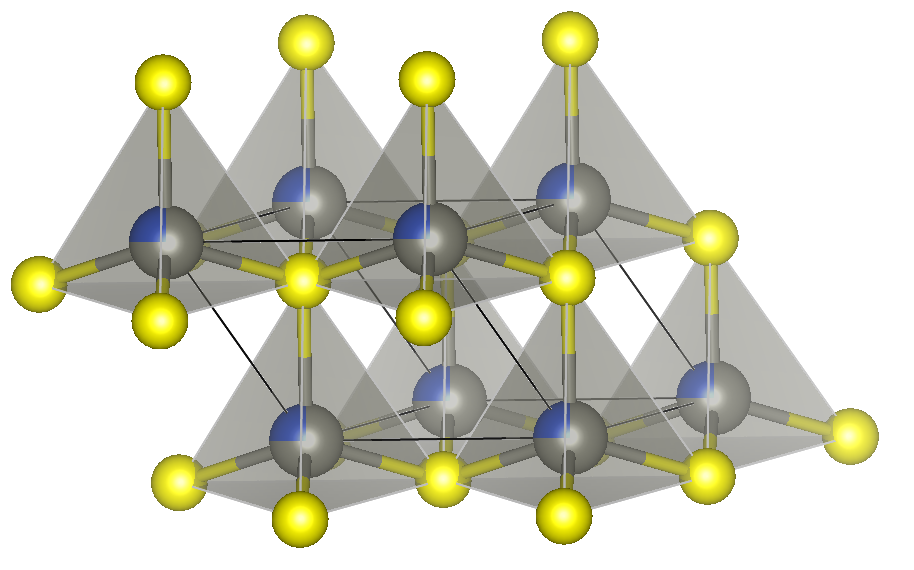

#### 
#### Transform structure

Though disorder may indeed be more representative of a real crystal structure, we need to convert this to an ordered structure to perform DFT calculations. Pymatgen supports a variety of structural "transformations" (a list of supported transformations is available https://pymatgen.org/pymatgen.transformations.html). Here are three methods from the `pymatgen.transformations.advanced_transformations` module to take a disordered structure, and order it:

1. `OrderDisorderStructureTransformation`: a highly simplified method to create an ordered supercell ranked by Ewald sums. USE WITH CARE!
2. `EnumerateStructureTransformation`: a method to order a disordered structure using `enumlib` (https://github.com/msg-byu/enumlib)
3. `SQSTransformation`: a method based on the `ATAT` code (Van de Walle et al. 2013, https://doi.org/10.1016/j.calphad.2013.06.006, and https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/) that creates a special quasirandom structure (SQS) from a structure with partial occupancies. Also use with care!

For this demo, we'll be focusing on the most simple transformation: `OrderDisorderStructureTransformation`

We have to be careful though!! If we just apply this transformation, it doesn't fail, but it returns a structure where all the Cu<sup>+</sup> is gone! `OrderDisorderedStructureTransformation` will round up or down if the cell is not large enough to account for x. Thus, we need to first make a supercell and then apply the transformation,

#### 
#### Make a supercell

With this transformation, we have to first create a disordered ***supercell*** to transform into. A supercell is just a structure that is scaled by a matrix. Here, the supercell must be large enough such that the composition in question can be achieved.

Let's scale the structure by 2 $\times$ 2 $\times$ 2 (a 2 $\times$ 2 $\times$ 1 supercell would be sufficient for `x = 1/4`, but this leaves room to try e.g. `x = 1/8`):

This is a list of ten ordered structures ranked by ***Ewald sum*** (dict key `"energy"`). Note that this does NOT correlate with the lowest energy structure! Let's just use the first entry for our example:

If you want to download this file

(note: "-0" is actually just 0, as this is a non-magnetic configuration)

BOOM! Now we have an alloy structure!! To view this structure you can upload your ".cif" file on crystal toolkit: https://materialsproject.org/#apps/xtaltoolkit

<img src="assets/Zn3CuS4_P-43m_estimate.png" style="max-width:50%">

### 
### EXERCISE: Try your own transformation on CuZnS<sub>2</sub>

Set a new composition, `x = 1/2` (simpler fractions are easier in DFT calculations because supercells can be smaller!). This will yield a structure with composition CuZnS<sub>2</sub>.

In [ ]:
x_CuZnS2 = 

In [ ]:
CuZnS2_disordered = ZnS_structure_oxi.copy()
CuZnS2_disordered.replace_species(
    {"Zn2+": {___: ___,
              ___: 1 - ___}}
)

Reminder: for more complex fractions, supercells need to be scaled accordingly!

In [ ]:
scaling_matrix = np.array([___, ___, ___])

In [ ]:
CuZnS2_disordered_supercell = CuZnS2_disordered * scaling_matrix

In [ ]:
CuZnS2_ordered_structures = odst.apply_transformation(___,
                                             return_ranked_list = ___)

Pick one:

In [ ]:
CuZnS2_ordered_structure = ___

In [ ]:
print(CuZnS2_ordered_structure)

Check that this is the composition you expect:

And check the space group:

Is it the same as ZnS? ___

# 
# 4. Calculate new properties!

### 
### LESSON: Volume prediction and XRD plot

So far we just have a really rough guess of an alloy structure, and the lattice parameters are still equal to those of ZnS. We can estimate the new volume $V_{x-guess}$ after the substitution using Vegard's Law (assuming zero bowing).

$V_{x-estimate} = V_{scaling } \times [ V_{CuS}(x) + V_{ZnS}(1-x) ] $

$V_{CuZn_3S_4-estimate} = [2\times2\times2] \times [ V_{CuS}(0.25) + V_{ZnS}(0.75) ] $

This is better but still wrong, and does not take into account any structural distortions. Note that there are some other methods on pymatgen to guess structure volume (see `pymatgen.analysis.structure_prediction.volume_predictor`), but in my experience Vegard's law is usually just as helpful. Your next step would be to relax this new structure using DFT (see below).

#### 
#### Calculate XRD, compare to original structure

Now we can compare this structure to our original ZnS and CuS structure to, for example, see how the ***X-ray diffraction (XRD)*** patterns are expected to shift as x increases in Cu<sub>x</sub>Zn<sub>1-x</sub>S:

Initialize the `XRDCalculator` with the conventional Cu-K$\alpha$ wavelength:

You can see how the peaks shift slightly to the right with Cu integration!

### 
### EXERCISE: try this on your CuZnS<sub>2</sub> structure

Guess the structure volume using Vegard's Law, and correct for this:

$V_{x-estimate} = V_{scaling } \times [ V_{CuS}(x) + V_{ZnS}(1-x) ] $

$V_{CuZnS_2-estimate} = [2\times2\times2] \times [ V_{CuS}(?) + V_{ZnS}(?) ] $

In [ ]:
x_CuZnS2

In [ ]:
scaling_volume

In [ ]:
CuZnS2_structure_estimate = CuZnS2_ordered_structure.copy()
CuZnS2_structure_estimate.scale_lattice(___

Print the new structure

In [ ]:
print(CuZnS2_structure_estimate)

Add this structure to the series of XRD plots to compare XRD for `x = 0, 0.25, 0.5, 1`:

In [ ]:
xrd.plot_structures([___], 
                                annotate_peaks=False, 
                                two_theta_range=[25,65], 
                                tight_layout=True, size_kwargs={'w': 10, 'h': 12}, fontsize=8)

# 
# 5. Test your skills

This is the wee beginning of making an alloy. Here are some follow-up steps:

<img src="assets/next_steps.png" style="max-width:60%">

I constructed similar alloys to those that we just explored, at `x = 1/4` and `x = 1/2`, and relaxed them with DFT. We'll explore my results here:

### EXERCISE: compare relaxed DFT structures to estimates

In [ ]:
from pymatgen import Structure

These are my output .cif files from "structure optimization" calculations (ions and electrons can move) followed by "static" refinements (only electrons can move). See `fireworks` and `atomate` packages for details (https://atomate.org/atomate.vasp.fireworks.html)

In [ ]:
CuZn3S4_relaxed = Structure.from_file("assets/Zn3CuS4_Amm2.cif")
CuZnS2_relaxed = Structure.from_file("assets/ZnCuS2_R3m.cif")

#### How do these space groups compare to our estimates?

Are they higher or lower in symmetry?

#### Add in DFT structure to XRD

Replace the alloy structures in the previous XRD exercise with the two relaxed alloy structures, again comparing XRD for `x = 0, 0.25, 0.5, 1`:

In [ ]:
xrd_plots = xrd.plot_structures([___], 
                                annotate_peaks=False, 
                                two_theta_range=[25,65], 
                                tight_layout=True, size_kwargs={'w': 10, 'h': 12}, fontsize=8)

Peak splittings are now present in the diffraction patterns, and the shift to higher 2 theta is not as significant.

***Scientific question: are these new phases stable?***

### LESSON: Add computed entries to phase diagram

To assess the stability of these new phases, let's look at JSON files containing `ComputedEntry` data:

We can add these two entries to `entries`, our set of `ComputedEntry` data from MP in the Cu-Zn-S phase space:

We see our two new phases show up here! Let's zoom into the binary diagram:

Because these phases break the binary hull, this shows that there is likely a stable phase of CuZnS<sub>2</sub>, though this may not be the lowest energy phase. Zn<sub>3</sub>CuS<sub>4</sub> is highly metastable. To explore other possibilities, one could perform a "structure prediction" in this chemical space.

### Next steps

Here are some follow-up calculations you can do to explore ternary space

* ***Structure Prediction***: To explore other possibilities of polymorphs in Cu-Zn-S ternary space, one could perform a "structure prediction" in this chemical space. You can use the Materials Project website's "Structure Prediction App": https://materialsproject.org/#apps/structurepredictor. There are also methods in `pymatgen.analysis.structure_prediction` to do this.
* ***DFT Calculations***: You can submit your structure(s) to MP by loading it with the crystal toolkit app (https://materialsproject.org/#apps/crystaltoolkit) and clicking "Submit to Materials Project". You can use `fireworks` and `atomate` to submit DFT calculations yourself to relax the structure, refine it, calculate band structure, and other properties
* ***Local Environment Analysis***: With your relaxed structures, you can upload your structure to crystal toolkit app (https://materialsproject.org/#apps/crystaltoolkit) and look at "Analyze: Local Environments" to compare coordination environments. You can also explore the methods in  
* ***Substrate Matcher***: If you want to grow this alloy structure epitaxially, you can explore different substrates to use on the website using methods in `pymatgen.analysis.substrate_analyzer module`

Thank you! Feel free to reach me at rwoodsrobinson@lbl.gov if you have any questions about this lesson